In [39]:
import os
import pickle
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np

import matplotlib.pyplot as plt
from collections import Counter
# import tifffile as tiff

In [40]:
# Function to load data from a directory
def load_data_from_directory(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'rb') as f:
            image, label = pickle.load(f)
            # Reshape or reorder image data if necessary (bands, height, width -> height, width, bands)
            image = np.transpose(image, (1, 2, 0))
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Paths to your data directories
train_dir = "data/classification_dataset/train"
validation_dir = "data/classification_dataset/validation"
test_dir = "data/classification_dataset/test"

# Load the data
train_images, train_labels = load_data_from_directory(train_dir)
val_images, val_labels = load_data_from_directory(validation_dir)
test_images, test_labels = load_data_from_directory(test_dir)

# Convert data to tf.data.Dataset
def create_tf_dataset(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    return dataset

train_dataset = create_tf_dataset(train_images, train_labels)
validation_dataset = create_tf_dataset(val_images, val_labels)
test_dataset = create_tf_dataset(test_images, test_labels)

# Batch and shuffle the datasets
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

(32, 32, 12) 0


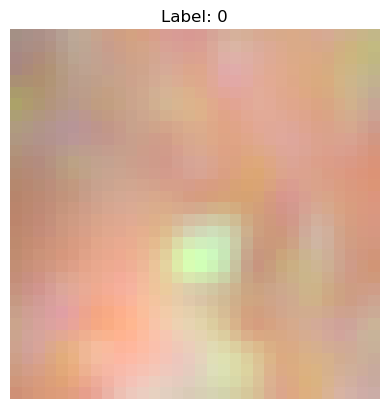

In [19]:
for images, labels in train_dataset.take(1):
    for i in range(1):
        print(images[i].shape, labels[i].numpy())
        image = images[i]
        label = labels[i]

        # Reshape or reorder image data if necessary (bands, height, width -> height, width, bands)
        #image = np.transpose(image, (1, 2, 0))  # (12, 32, 32) -> (32, 32, 12)

        # Select RGB bands (e.g., bands 4, 3, 2 from Sentinel-2, adjust if needed)
        rgb_image = np.stack([
            image[:, :, 3],  # Band 4 (Red)
            image[:, :, 2],  # Band 3 (Green)
            image[:, :, 1]   # Band 2 (Blue)
        ], axis=-1)
        
        # Normalize the RGB image for saving
        rgb_image = (rgb_image / np.max(rgb_image) * 255).astype(np.uint8)

        # Save the image as a TIFF file
        # tiff.imwrite('rgb_image.tiff', rgb_image)
        # print("Image saved as 'rgb_image.tiff'")

        # Display the RGB image
        plt.imshow(rgb_image)
        plt.title(f"Label: {label.numpy()}")
        plt.axis("off")
        plt.show()


In [4]:
#Use class weights in model to re-balance the data

In [20]:
#Size of training data
for image_batch, labels_batch in train_dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)

(32, 32, 32, 12)
(32,)


In [21]:
TARGET_SHAPE = (-1, 32, 32,12)

def reshape_tensors(image_batch, labels_batch):
    image_batch = tf.reshape(image_batch, shape=TARGET_SHAPE)
    return image_batch, labels_batch

#train_dataset = train_dataset.map(reshape_tensors, num_parallel_calls=tf.data.AUTOTUNE)
#validation_dataset = validation_dataset.map(reshape_tensors, num_parallel_calls=tf.data.AUTOTUNE)
#test_dataset = test_dataset.map(reshape_tensors, num_parallel_calls=tf.data.AUTOTUNE)


In [22]:
for image_batch, labels_batch in train_dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)

(32, 32, 32, 12)
(32,)


In [23]:
img_height = 32
img_width = 32

In [24]:
batch_size = 32

In [28]:
num_classes = 2

model = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  layers.Conv2D(16, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
#model.summary()

In [31]:
#Input to reshape is a tensor with 380928 values, but the requested shape has 393216

test = 380928/(32*32*12)
print(test)

31.0


In [ ]:
epochs=10
history_2 = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)
#no_classweights_10_ephocs

Epoch 1/10


2024-12-06 10:30:00.001895: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1673/1673 [==============================] - 139s 82ms/step - loss: 0.2846 - accuracy: 0.8544 - val_loss: 0.5976 - val_accuracy: 0.6903
Epoch 2/10
1673/1673 [==============================] - 153s 91ms/step - loss: 0.2314 - accuracy: 0.8878 - val_loss: 0.3797 - val_accuracy: 0.8038
Epoch 3/10
1673/1673 [==============================] - 157s 94ms/step - loss: 0.2059 - accuracy: 0.9015 - val_loss: 0.4539 - val_accuracy: 0.7595
Epoch 4/10
1673/1673 [==============================] - 156s 93ms/step - loss: 0.1914 - accuracy: 0.9090 - val_loss: 0.3290 - val_accuracy: 0.8579
Epoch 5/10
1673/1673 [==============================] - 153s 91ms/step - loss: 0.1867 - accuracy: 0.9114 - val_loss: 0.3379 - val_accuracy: 0.8398
Epoch 6/10
1673/1673 [==============================] - 150s 89ms/step - loss: 0.1817 - accuracy: 0.9140 - val_loss: 0.3591 - val_accuracy: 0.8335
Epoch 7/10
1673/1673 [==============================] - 155s 93ms/step - loss: 0.1817 - accuracy: 0.9147 - val_loss: 0.3630 - val

In [38]:
# Save the entire model as a `.keras` zip archive.
model.save('no_classweights_10_epochs_augmentation.keras')

In [39]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

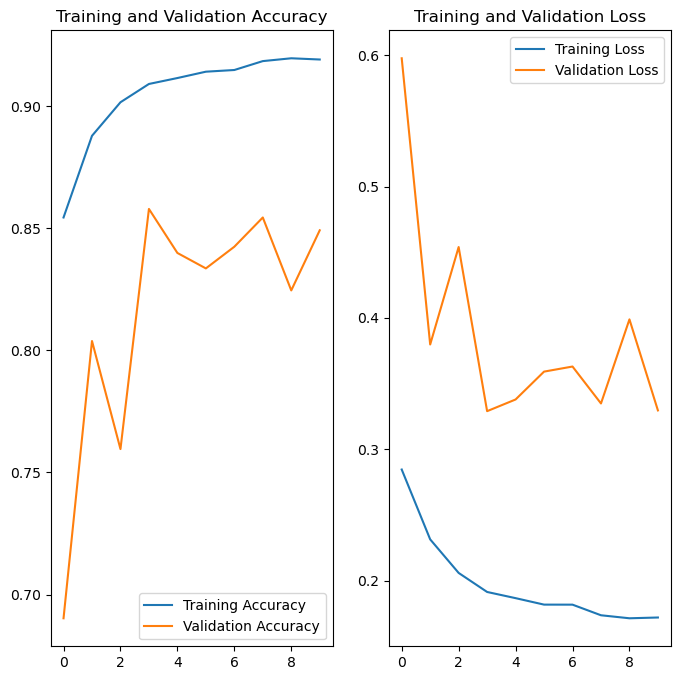

In [40]:
plot_results(history_2)

## Training with class weights

In [19]:
def calculate_class_weights(dataset):
    # Extract all labels from the dataset
    all_labels = []
    for _, labels in dataset:
        all_labels.extend(labels.numpy())

    # Count the occurrences of each class
    label_counts = Counter(all_labels)

    # Total number of samples
    total_samples = sum(label_counts.values())

    # Calculate weights for each class
    class_weights = {label: total_samples / (len(label_counts) * count) 
                     for label, count in label_counts.items()}

    return class_weights

# Calculate class weights for the train_dataset
class_weights = calculate_class_weights(train_dataset)
print("Class Weights:", class_weights)

Class Weights: {0: 0.5864792620670012, 1: 3.390866480871548}


In [42]:
epochs=10
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  class_weight = class_weights
)

Epoch 1/10
1673/1673 [==============================] - 138s 81ms/step - loss: 0.2408 - accuracy: 0.8708 - val_loss: 0.2381 - val_accuracy: 0.8973
Epoch 2/10
1673/1673 [==============================] - 168s 100ms/step - loss: 0.2242 - accuracy: 0.8815 - val_loss: 0.2089 - val_accuracy: 0.9145
Epoch 3/10
1673/1673 [==============================] - 163s 97ms/step - loss: 0.2337 - accuracy: 0.8718 - val_loss: 0.2182 - val_accuracy: 0.9131
Epoch 4/10
1673/1673 [==============================] - 162s 97ms/step - loss: 0.2262 - accuracy: 0.8762 - val_loss: 0.2090 - val_accuracy: 0.9161
Epoch 5/10
1673/1673 [==============================] - 154s 92ms/step - loss: 0.2193 - accuracy: 0.8808 - val_loss: 0.2425 - val_accuracy: 0.8920
Epoch 6/10
1673/1673 [==============================] - 173s 103ms/step - loss: 0.2164 - accuracy: 0.8814 - val_loss: 0.2105 - val_accuracy: 0.9155
Epoch 7/10
1673/1673 [==============================] - 165s 99ms/step - loss: 0.2256 - accuracy: 0.8784 - val_loss:

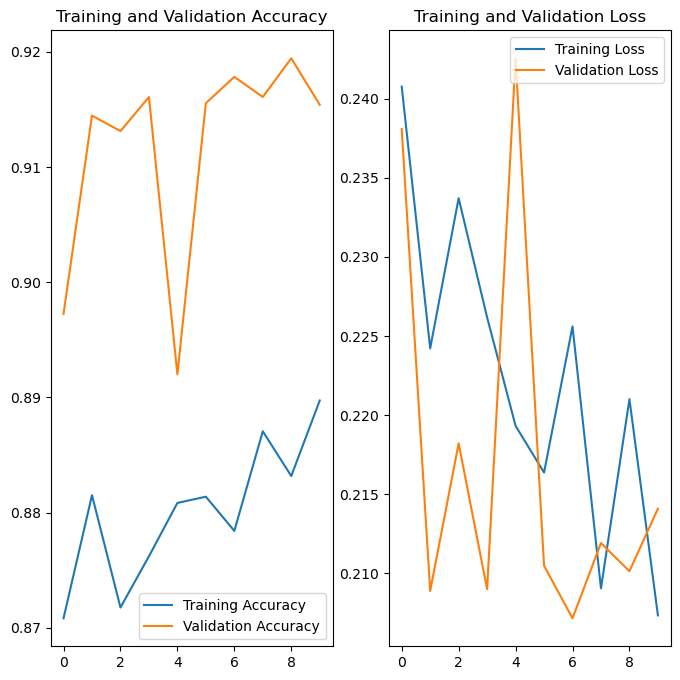

In [43]:
plot_results(history)

In [44]:
model.save('with_classweights_10_epochs_augmentation.keras')

### To do some visualizations!

233/233 [==============================] - 4s 18ms/step


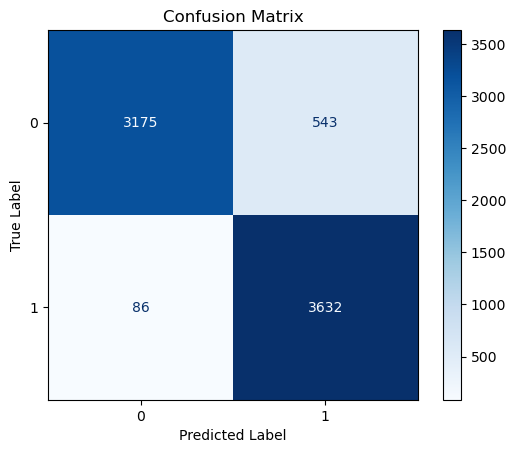

In [ ]:
# True labels and predictions
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)  
y_pred = np.argmax(model.predict(validation_dataset), axis=1)       

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Customize plot (optional)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### RGB + NIR image

In [25]:
def filter_rgb_nir(images):
    return images[:, :, :, [3, 2, 1, 7]]  # Bands: Red (4), Green (3), Blue (2), NIR (8)

# Filter datasets
train_images_rgb_nir = filter_rgb_nir(train_images)
val_images_rgb_nir = filter_rgb_nir(val_images)
test_images_rgb_nir = filter_rgb_nir(test_images)

# Define the model for RGB + NIR bands
model_rgb_nir = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    layers.Conv2D(16, 12, padding='same', activation='relu', input_shape=(32, 32, 4)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 12, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 12, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2)  # Binary classification
])

# Compile the model
model_rgb_nir.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [26]:
# Convert the filtered data to TensorFlow datasets
train_dataset_rgb_nir = tf.data.Dataset.from_tensor_slices((train_images_rgb_nir, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset_rgb_nir = tf.data.Dataset.from_tensor_slices((val_images_rgb_nir, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Train the model
history_rgb_nir = model_rgb_nir.fit(
    train_dataset_rgb_nir,
    validation_data=validation_dataset_rgb_nir,
    epochs=10,
    class_weight=class_weights
)

# Save the model
model_rgb_nir.save('model_rgb_nir.keras')

Epoch 1/10
1673/1673 [==============================] - 97s 57ms/step - loss: 0.4201 - accuracy: 0.6983 - val_loss: 0.3892 - val_accuracy: 0.8229
Epoch 2/10
1673/1673 [==============================] - 96s 57ms/step - loss: 0.3945 - accuracy: 0.7014 - val_loss: 0.3852 - val_accuracy: 0.8248
Epoch 3/10
1673/1673 [==============================] - 102s 61ms/step - loss: 0.3877 - accuracy: 0.7026 - val_loss: 0.3813 - val_accuracy: 0.8202
Epoch 4/10
1673/1673 [==============================] - 105s 63ms/step - loss: 0.3511 - accuracy: 0.7243 - val_loss: 0.3134 - val_accuracy: 0.8464
Epoch 5/10
1673/1673 [==============================] - 107s 64ms/step - loss: 0.3237 - accuracy: 0.7867 - val_loss: 0.2962 - val_accuracy: 0.8761
Epoch 6/10
1673/1673 [==============================] - 107s 64ms/step - loss: 0.3082 - accuracy: 0.8084 - val_loss: 0.2998 - val_accuracy: 0.8740
Epoch 7/10
1673/1673 [==============================] - 109s 65ms/step - loss: 0.3015 - accuracy: 0.8223 - val_loss: 0.2

233/233 [==============================] - 3s 13ms/step


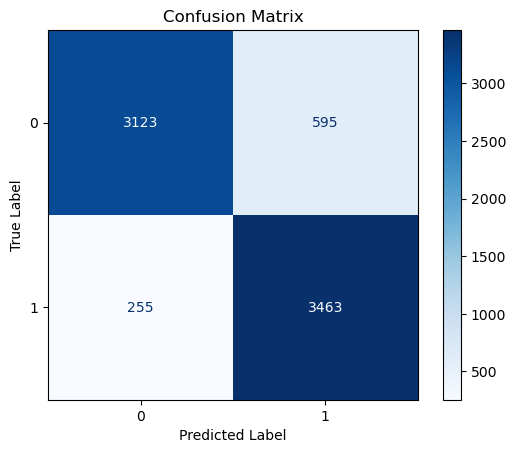

In [33]:
# True labels and predictions
y_true = np.concatenate([y for x, y in validation_dataset_rgb_nir], axis=0)  
y_pred = np.argmax(model_rgb_nir.predict(validation_dataset_rgb_nir), axis=1)       

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Customize plot (optional)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [34]:
# Filter only RGB bands
def filter_rgb(images):
    return images[:, :, :, [3, 2, 1]]  # Bands: Red (4), Green (3), Blue (2)

# Filter datasets
train_images_rgb = filter_rgb(train_images)
val_images_rgb = filter_rgb(val_images)
test_images_rgb = filter_rgb(test_images)

In [35]:
# Define the model for RGB bands
model_rgb = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    layers.Conv2D(16, 12, padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 12, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 12, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2)  # Binary classification
])

# Compile the model
model_rgb.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Convert the filtered data to TensorFlow datasets
train_dataset_rgb = tf.data.Dataset.from_tensor_slices((train_images_rgb, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset_rgb = tf.data.Dataset.from_tensor_slices((val_images_rgb, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Train the model
history_rgb = model_rgb.fit(
    train_dataset_rgb,
    validation_data=validation_dataset_rgb,
    epochs=10,
    class_weight=class_weights
)

# Save the model
model_rgb.save('model_rgb.keras')

Epoch 1/10
1673/1673 [==============================] - 96s 57ms/step - loss: 0.4070 - accuracy: 0.7187 - val_loss: 0.3911 - val_accuracy: 0.8148
Epoch 2/10
1673/1673 [==============================] - 100s 59ms/step - loss: 0.3847 - accuracy: 0.7277 - val_loss: 0.3723 - val_accuracy: 0.8178
Epoch 3/10
1673/1673 [==============================] - 118s 70ms/step - loss: 0.3556 - accuracy: 0.7318 - val_loss: 0.3382 - val_accuracy: 0.8373
Epoch 4/10
1673/1673 [==============================] - 117s 70ms/step - loss: 0.3349 - accuracy: 0.7752 - val_loss: 0.3557 - val_accuracy: 0.8265
Epoch 5/10
1673/1673 [==============================] - 118s 71ms/step - loss: 0.3145 - accuracy: 0.8098 - val_loss: 0.2974 - val_accuracy: 0.8728
Epoch 6/10
1673/1673 [==============================] - 119s 71ms/step - loss: 0.3097 - accuracy: 0.8227 - val_loss: 0.3041 - val_accuracy: 0.8700
Epoch 7/10
1673/1673 [==============================] - 116s 69ms/step - loss: 0.3062 - accuracy: 0.8187 - val_loss: 0.

233/233 [==============================] - 3s 14ms/step


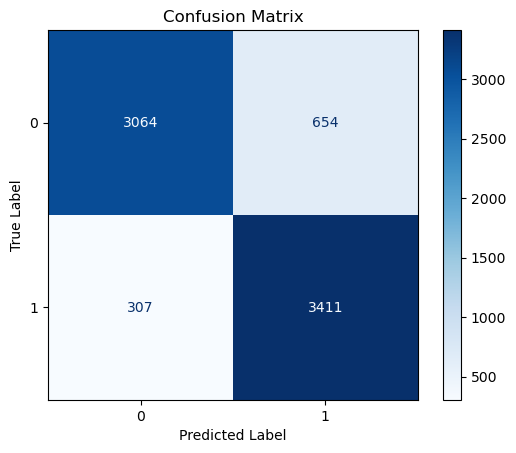

In [37]:
# True labels and predictions
y_true = np.concatenate([y for x, y in validation_dataset_rgb], axis=0)  
y_pred = np.argmax(model_rgb.predict(validation_dataset_rgb), axis=1)       

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Customize plot (optional)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()